# Global Food Prices

Get dataset

In [11]:
import os
from download import download
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline


url = "http://vam.wfp.org/sites/data/WFPVAM_FoodPrices_05-12-2017.csv"
file_name = 'WFPVAM_FoodPrices_05-12-2017.csv'

def get_dataset(url, file_name):
    if not os.path.isfile(file_name):
        download(url, file_name)
    
    return pd.read_csv(file_name, encoding='latin-1')

df = get_dataset(url, file_name)

In [2]:
# Pre-process

['adm0_id', 'adm0_name', 'adm1_id', 'adm1_name', 'mkt_id', 'mkt_name', 'cm_id', 'cm_name', 'cur_id', 'cur_name', 'pt_id', 'pt_name', 'um_id', 'um_name', 'mp_month', 'mp_year', 'mp_price', 'mp_commoditysource']


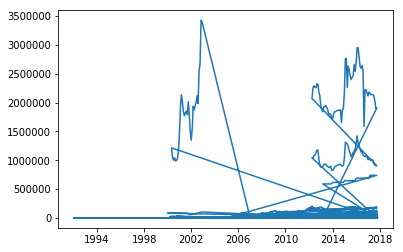

In [12]:
# Get average prices
print(df.columns.values.tolist())
# avg_prices = df.loc[df['mp_prices']]

df['datetime'] = pd.to_datetime(df.mp_year*10000+df.mp_month*100+1, format='%Y%m%d')

avg_price = df.groupby(['adm0_name', 'cm_name', 'datetime'])['mp_price']



df_means = avg_price.mean().reset_index()


plt.plot(df_means['datetime'], df_means['mp_price'], '-')
